# Initialize Google Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
main_path = "/content/drive/MyDrive/Colab Notebooks/"
file = "SMSSpamCollection.txt"

# Load data and make columns: *text* and *label*

In [9]:
import pandas as pd
import os

df = pd.read_csv(os.path.join(main_path, "data", file), sep='\t',
                           names=["category", "text"])
df["label"] = df["category"].astype("category").cat.codes
df.head()

,category,text,label
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
df.shape

(5572, 3)

In [11]:
X=list(df['text'])
y=list(df['label'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.50, random_state = 0)

# Load tokenizer and Bert model

In [ ]:
!pip install transformers

In [14]:
import transformers
print(transformers.__version__)

4.30.2


In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Preprocess data

In [20]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)
val_encodings = tokenizer(X_val, truncation=True, padding=True)

In [21]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))

# Fine-tuned Bert model

In [23]:
model.layers[0].trainable = False
model.layers[1].trainable = False

In [24]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,955,010
Trainable params: 1,538
Non-trainable params: 66,953,472
_________________________________________________________________


We are going to train only 1,538 parameters. It's very low knowing the task that is been given, but because the Bert architechture part takes care of understanding the lenguage, maybe we dont need much study just to make a simple binary separation.

The fact that i'm choosing to train only those parameters is also because of the trainning time.

In [25]:
model.compile(optimizer="adam")

In [29]:
model.fit(train_dataset, validation_data=test_dataset, epochs=3, batch_size=64)

Epoch 1/3
4179/4179 [==============================] - 1442s 345ms/step - loss: 0.1396 - val_loss: 0.0739
Epoch 2/3
4179/4179 [==============================] - 1434s 343ms/step - loss: 0.0734 - val_loss: 0.0596
Epoch 3/3
4179/4179 [==============================] - 1456s 348ms/step - loss: 0.0645 - val_loss: 0.0587


# Save tokenizer and Model

In [30]:
savepath = "/content/drive/MyDrive/Colab Notebooks/models/sentiment_analysis"

In [31]:
model.save_pretrained(savepath)
tokenizer.save_pretrained(savepath)

('/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/sentiment_analysis/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/sentiment_analysis/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/sentiment_analysis/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/sentiment_analysis/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/ABRICOT/Telcel/NLP/models/sentiment_analysis/tokenizer.json')

# Predictions

In [33]:
from transformers import TextClassificationPipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [34]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

In [35]:
pred = pipeline(X_test)

In [43]:
print(pred[0])
int(pred[0]["label"][-1])

{'label': 'LABEL_0', 'score': 0.8320313096046448}


0

In [44]:
pred = [int(p["label"][-1]) for p in pred]

array([[594,   8],
       [  6,  88]])

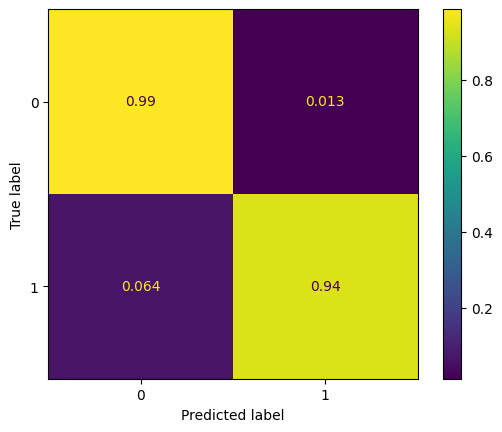

In [49]:
cm = confusion_matrix(y_test ,pred)
cm2 = np.array([cm[i]/cm[i].sum() for i in range(len(cm))])

cm_display = ConfusionMatrixDisplay(cm2).plot()
cm

We end up with more than 95% accuracy, so they are good results!